# Images and convolutional networks

In this notebook, we'll cover the use of convolutional neural networks for image classification.

## Preamble: GPUs

Since these networks widely benefit from computations on GPU, you could be curious about whether GPUs will be used for the computations at stake in this notebook.

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found


If you are using Google Colab and no GPU is found, enable GPUs for the notebook as follows:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

and restart the notebook.

By default, all operations in `keras` are run on GPU if a GPU is found.
If no GPU is available, the code runs on CPU without requiring any adaptation.

## Fully connected networks (Multi Layer Perceptrons)

You will first experiment with multi-layer perceptrons to get used to the basics of model definition and training in `keras`.


**Question 1.** Import the MNIST dataset and make sure it has the correct shape to feed a MLP (i.e. the dataset should 
have dimensions $(n, p)$ where $n$ is the number of images in the set, $p=w \times h\times c$ is the number of features, $w$ and $h$ are the width and height of an 
image and $c$ its number of channels: 1 for black & white images and 3 for RGB ones).

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

def prepare_mnist_mlp():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.
    x_test = x_test / 255.
    x_train = x_train.reshape((-1, 28 * 28))
    x_test = x_test.reshape((-1, 28 * 28))
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = prepare_mnist_mlp()

In [8]:
print(x_train.shape, y_train.shape)
print(y_train[1])

(60000, 784) (60000, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


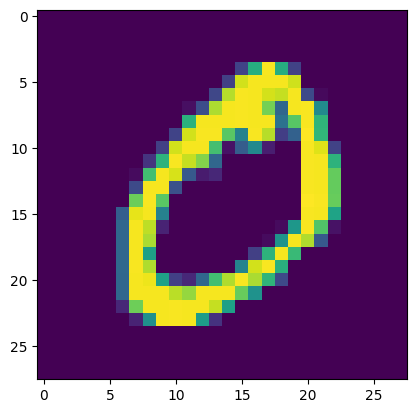

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(x_train[1].reshape((28, 28)))

To define an MLP, you will need (at least) the following layers:
* [`InputLayer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer)
* [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

**Question 2.** Implement an MLP with a single hidden layer made of 128 neurons. Show the number of parameters of this network (using `model.count_params()` or `model.summary()`) and evaluate its performance on MNIST test data.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense

model = Sequential([
    InputLayer(input_shape=(784, )),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(x_train, y_train, batch_size=100, epochs=10, validation_split=.3)

Epoch 1/10
420/420 [==============================] - 2s 3ms/step - loss: 0.3818 - accuracy: 0.8949 - val_loss: 0.2225 - val_accuracy: 0.9355
Epoch 2/10
420/420 [==============================] - 1s 3ms/step - loss: 0.1795 - accuracy: 0.9485 - val_loss: 0.1674 - val_accuracy: 0.9516
Epoch 3/10
420/420 [==============================] - 2s 4ms/step - loss: 0.1312 - accuracy: 0.9616 - val_loss: 0.1383 - val_accuracy: 0.9599
Epoch 4/10
420/420 [==============================] - 2s 4ms/step - loss: 0.1009 - accuracy: 0.9714 - val_loss: 0.1210 - val_accuracy: 0.9650
Epoch 5/10
420/420 [==============================] - 2s 4ms/step - loss: 0.0804 - accuracy: 0.9772 - val_loss: 0.1165 - val_accuracy: 0.9656
Epoch 6/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0664 - accuracy: 0.9810 - val_loss: 0.1091 - val_accuracy: 0.9683
Epoch 7/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0547 - accuracy: 0.9844 - val_loss: 0.1028 - val_accuracy: 0.9701
Epoch 

In [16]:
print(h.history)

{'loss': [0.3817586600780487, 0.1795424222946167, 0.13123267889022827, 0.1009255051612854, 0.08044950664043427, 0.06639372557401657, 0.0547073669731617, 0.04469303786754608, 0.038085028529167175, 0.03185340017080307], 'accuracy': [0.8948571681976318, 0.9484761953353882, 0.9616190195083618, 0.9714285731315613, 0.9772142767906189, 0.9810237884521484, 0.9844285845756531, 0.9880475997924805, 0.9897381067276001, 0.9916428327560425], 'val_loss': [0.2224821150302887, 0.16740208864212036, 0.13825391232967377, 0.12103240191936493, 0.11645711213350296, 0.1090516597032547, 0.10281991213560104, 0.09970320761203766, 0.09893355518579483, 0.11403997242450714], 'val_accuracy': [0.9355000257492065, 0.9515555500984192, 0.9598888754844666, 0.9649999737739563, 0.9656111001968384, 0.9682777523994446, 0.9701111316680908, 0.9710555672645569, 0.9717222452163696, 0.9671666622161865]}


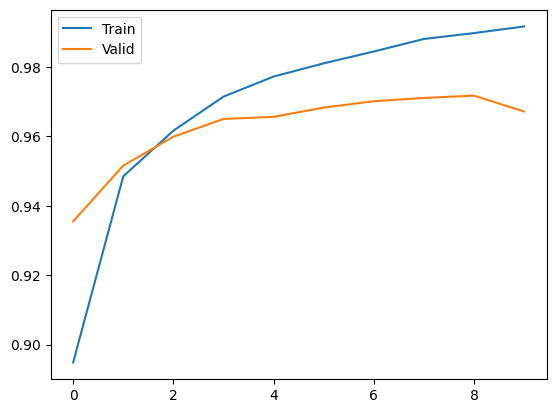

In [18]:
plt.plot(h.history["accuracy"], label="Train")
plt.plot(h.history["val_accuracy"], label="Valid")
plt.legend();

In [19]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.0905 - accuracy: 0.9715


[0.09045195579528809, 0.9714999794960022]

## LeNet and variants (shallow CNNs)

You will now experiment with rather shallow convolutional networks to get used to typical layers used in CNNs.


**Question 3.** Import the MNIST dataset and make sure it has the correct shape to feed a CNN (i.e. the dataset should 
have dimensions $(n, w, h, c)$ where $n$ is the number of images in the set, $w$ and $h$ are the width and height of an 
image and $c$ its number of channels: 1 for black & white images and 3 for RGB ones).

In [20]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

def prepare_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.
    x_test = x_test / 255.
    x_train = x_train.reshape((-1, 28, 28, 1))
    x_test = x_test.reshape((-1, 28, 28, 1))
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = prepare_mnist()

To define a CNN, you will need (at least) the following layers:
* [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
* [`MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)
* [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

**Question 4.** Implement a CNN with a single convolutional layer followed by a max-pooling and a fully-connected layer. Show the number of parameters of these networks and evaluate its performance on MNIST test data.

In [22]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

model = Sequential([
    InputLayer(input_shape=(28, 28, 1)),
    Conv2D(filters=128, kernel_size=5, activation="relu"),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(10, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(x_train, y_train, batch_size=100, epochs=10, validation_split=.3)

Epoch 1/10
420/420 [==============================] - 31s 71ms/step - loss: 0.2368 - accuracy: 0.9319 - val_loss: 0.0891 - val_accuracy: 0.9753
Epoch 2/10
420/420 [==============================] - 29s 68ms/step - loss: 0.0704 - accuracy: 0.9794 - val_loss: 0.0700 - val_accuracy: 0.9786
Epoch 3/10
420/420 [==============================] - 30s 72ms/step - loss: 0.0501 - accuracy: 0.9849 - val_loss: 0.0622 - val_accuracy: 0.9811
Epoch 4/10
420/420 [==============================] - 30s 71ms/step - loss: 0.0404 - accuracy: 0.9877 - val_loss: 0.0573 - val_accuracy: 0.9832
Epoch 5/10
420/420 [==============================] - 29s 69ms/step - loss: 0.0321 - accuracy: 0.9902 - val_loss: 0.0579 - val_accuracy: 0.9826
Epoch 6/10
420/420 [==============================] - 29s 69ms/step - loss: 0.0262 - accuracy: 0.9918 - val_loss: 0.0571 - val_accuracy: 0.9832
Epoch 7/10
420/420 [==============================] - 29s 69ms/step - loss: 0.0212 - accuracy: 0.9935 - val_loss: 0.0568 - val_accuracy:

**Question 5.** Implement the following network (leNet):

![leNet model](https://github.com/rtavenar/deep-notebooks/raw/main/assets/convnet_fig.svg)

Compare its performance to that of the fully connected model you have defined in the first section of this notebook.

In [24]:
model = Sequential([
    InputLayer(input_shape=(28, 28, 1)),
    Conv2D(filters=6, kernel_size=5, activation="relu", padding="valid"),
    MaxPool2D(pool_size=2),
    Conv2D(filters=16, kernel_size=5, activation="relu", padding="valid"),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(120, activation="relu"),
    Dense(84, activation="relu"),
    Dense(10, activation="softmax")
])
# model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(x_train, y_train, batch_size=100, epochs=10, validation_split=.3)

Epoch 1/10
420/420 [==============================] - 13s 31ms/step - loss: 0.3658 - accuracy: 0.8930 - val_loss: 0.1107 - val_accuracy: 0.9669
Epoch 2/10
420/420 [==============================] - 13s 32ms/step - loss: 0.0916 - accuracy: 0.9721 - val_loss: 0.1054 - val_accuracy: 0.9666
Epoch 3/10
420/420 [==============================] - 13s 32ms/step - loss: 0.0666 - accuracy: 0.9800 - val_loss: 0.0732 - val_accuracy: 0.9771
Epoch 4/10
420/420 [==============================] - 13s 32ms/step - loss: 0.0523 - accuracy: 0.9833 - val_loss: 0.0613 - val_accuracy: 0.9818
Epoch 5/10
420/420 [==============================] - 13s 32ms/step - loss: 0.0413 - accuracy: 0.9867 - val_loss: 0.0629 - val_accuracy: 0.9813
Epoch 6/10
420/420 [==============================] - 14s 33ms/step - loss: 0.0358 - accuracy: 0.9892 - val_loss: 0.0572 - val_accuracy: 0.9836
Epoch 7/10
420/420 [==============================] - 13s 32ms/step - loss: 0.0293 - accuracy: 0.9905 - val_loss: 0.0609 - val_accuracy:

## Image classification with ResNet models

A very efficient way to perform real-world image classification is to rely on a pretrained model.
`keras` provides models trained on ImageNet.
In this section, you will use `ResNet50` to classify images you will provide.

**Question 6.** Adapt the following code (that comes from [`keras` docs](https://keras.io/applications/#usage-examples-for-image-classification-models)) to classify a kangaroo image that you will first upload in the notebook files.

In [25]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = 'kangaroo.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n01877812', 'wallaby', 0.9021192), ('n02423022', 'gazelle', 0.045051575), ('n02417914', 'ibex', 0.015986549)]


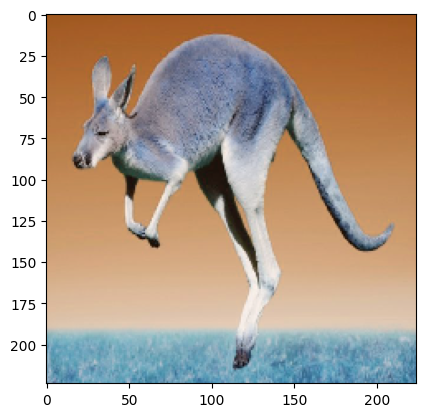

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow((x[0] - x.min()) / (x.max() - x.min()));

## Fine-tuning a model to your data

Very often, however, your image classification problem will not match ImageNet classes.
In such cases, a typical strategy consists in fine-tuning an existing model to your problem.
This is done by learning only the fully connected layers at the ouput of the model and keep other layers freezed.

When loading weights from a pretrained model, `keras` offers an option to remove the classification layers and freeze weights of the convolutional layers:

```python
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=x_train.shape[1:])
for layer in base_model.layers:
  layer.trainable = False
```

Note that here, we provide the image shape when re-building the `ResNet50` model so that, if that shape is not the one of ImageNet images, `keras` will still be able to compute all tensor shapes in the network automatically.

From that point, `base_model` can be used in a `Sequential` model as if it were a single layer, which makes it feasible to plug new layers at the output of the `ResNet50` convolutions.

### The dataset

In this notebook, you will work with a new dataset that cannot be loaded via `keras.datasets` module.
Depending in the platform on which you run this notebook, you will have to follow different guidelines to prepare the required files for the following steps.

<details><summary>If you use Google Colab...</summary>

The images should be [stored](https://drive.google.com/drive/folders/1_hs6-moToZkCgiub7eXyJmAm7zVT2tNo?usp=sharing) on your Google Drive account, in a subfolder named `./cats_and_dogs/`.

Once this done, copy/paste the following code in the code block below to set the path to the data:

```python
from google.colab import drive
drive.mount('/content/drive')
folder_data = '/content/drive/My Drive/cats_and_dogs/'
```
</details>

<details><summary>If you use your own computer</summary>

The images should be [downloaded and stored](https://drive.google.com/drive/folders/1_hs6-moToZkCgiub7eXyJmAm7zVT2tNo?usp=sharing) in a subfolder of your working directory named `./cats_and_dogs/`.

Once this done, copy/paste the following code in the code block below to set the path to the data:

```python
folder_data = './cats_and_dogs/'
```
</details>

Now, whatever your platform, run the cell below:

In [ ]:
!ls './cats_and_dogs/'

The last line of the output above should be:
```
test_catdog  train_catdog
```

Then the data should be loaded using the following functions:

In [ ]:
import os

def load_cats_and_dogs_folder(path, target_size=None, verbose=True):
    X = []
    y = []
    i = 0
    for fname in os.listdir(path):
        if 'cat' in fname:
            X.append(
                np.array(image.load_img(path+fname, target_size=target_size))
            )
            y.append(0)
        elif 'dog' in fname:
            X.append(
                np.array(image.load_img(path+fname, target_size=target_size))
            )
            y.append(1)
        i+=1
        if verbose and i % 50 == 0:
            print('{0:.2f} % loaded'.format(100*(i/len(os.listdir(path)))))
    return np.array(X), np.array(y)

def load_preprocessed_cats_and_dogs(base_folder, target_size=None, 
                                    verbose=True):
    if verbose:
        print("Loading training set")
    X_train, y_train = load_cats_and_dogs_folder(base_folder + "/train_catdog/", 
                                                 target_size=target_size,
                                                 verbose=verbose)
    X_train = preprocess_input(X_train)

    if verbose:
        print("Loading test set")
    X_test, y_test = load_cats_and_dogs_folder(base_folder + "/test_catdog/", 
                                               target_size=target_size,
                                               verbose=verbose)
    X_test = preprocess_input(X_test)

    return X_train, X_test, y_train, y_test

# The call is here:
X_train, X_test, y_train, y_test = load_preprocessed_cats_and_dogs(folder_data, target_size=(200, 200))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 

### The model

**Question 7.** Now you will:

1. use convolution layers from a pre-trained `ResNet50` model and freeze them;
2. plug an additional logistic regression layer;
3. compile the full model;
4. observe the performance of such a model on your Cat vs Dog problem.

**Question 8.** Starting from the model you got at the previous stage, fine-tune _all_ the weights in this model
(even the convolution ones) using a learning rate of .00001 (1e-5). See if this improves on performance.